### PCA Across Time: Right Lateral  
  
This notebook is for reducing the row dimension of my EEGs. Each EEG has 200 rows of data per second. The first step is to figure out why scikit learn won't perform PCA on a transposed EEG. It wants to do PCA on the 20 electrodes whether they're the columns or the rows. One possible solution is to take individual electrodes separately and then stack them to fix the dimension issue scikit learn is having. So you'd have an Fp1 matrix, an Fp2 matrix, an F3 matrix, etc. You would then transpose these matrices. To help explain, in the Fp1 matrix, each row would be the Fp1 signal for a single sub EEG and the columns would be time. You could stack 10k Fp1 electrode signals and get a 10k by 10k matrix (10k columns because sub EEGs are 50 seconds long and the sampling frequency is 200).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fastparquet, pyarrow
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

##### Loading and Splitting Data

In [2]:
df = pd.read_csv('working_data.csv')

def activity_df(activity):
    return pd.DataFrame(df[df['expert_consensus'] == activity]).reset_index().drop(columns = 'index')

other_df = activity_df('Other')
seizure_df = activity_df('Seizure')
lpd_df = activity_df('LPD')
gpd_df = activity_df('GPD')
lrda_df = activity_df('LRDA')
grda_df = activity_df('GRDA')

##### Functions to Scale, Perform PCA, and Plot Signals

In [3]:
def scale(df, row):
    eeg = pd.read_parquet('train_eegs/{}.parquet'.format(df['eeg_id'][row]), engine = 'pyarrow')
    first_row = int(df['eeg_label_offset_seconds'][row] * 200)
    last_row = int(first_row + 10000)
    sub_eeg = eeg[first_row: last_row]
    electrodes = sub_eeg.columns
    scaler = StandardScaler()
    sub_eeg = scaler.fit_transform(sub_eeg)
    sub_eeg = pd.DataFrame(sub_eeg, columns = electrodes)
    return sub_eeg

def activity_signal_plots(sub_eegs, activities, electrodes, h, w):
    fig, axs = plt.subplots(len(electrodes), len(sub_eegs))
    fig.set_figheight(h)
    fig.set_figwidth(w)
    fig.tight_layout()
    for i in range(len(electrodes)):
        if len(sub_eegs) == 1:
            axs[i].plot(sub_eegs[0][electrodes[i]])
            axs[i].set_title('{}_{}'.format(activities[0], electrodes[i]))
        else:
            for j in range(len(sub_eegs)):
                axs[i][j].plot(sub_eegs[j][electrodes[i]])
                if len(activities) > 1:
                    axs[i][j].set_title('{}_{}'.format(activities[j], electrodes[i]))
                else:
                    axs[i][j].set_title('{}_{}'.format(activities[0], electrodes[i]))
    plt.show()

def pca_function(sub_eeg, n):
    sub_eeg = sub_eeg.transpose()
    pca = PCA(n_components = n, random_state = 42)
    sub_eeg = pca.fit_transform(sub_eeg)
    ratios = pca.explained_variance_ratio_
    eigenvalues = pca.explained_variance_
    values = pca.singular_values_
    sub_eeg = pd.DataFrame(sub_eeg)
    return sub_eeg, ratios, values, eigenvalues

### Fp2

In [4]:
fp2_signals = pd.read_parquet('electrode_matrices/Fp2_signals.parquet', engine = 'pyarrow')

In [5]:
fp2_pca, fp2_ratios, fp2_svalues, fp2_evalues = pca_function(fp2_signals, 400)

In [6]:
activity_indexes = pd.read_csv('activity_indexes.csv')

In [7]:
activity_indexes.head()

,activity_type,index
0,LRDA,51059
1,GRDA,28199
2,Other,43859
3,GRDA,37540
4,Other,63591


In [8]:
fp2_pca = fp2_pca.transpose()

In [9]:
fp2_pca.columns = ['Fp2_{}_{}'.format(activity_indexes['activity_type'][i], activity_indexes['index'][i]) 
                 for i in range(activity_indexes.shape[0])]

##### Column Labels  
  
The format of the column labels electrode_activity_index. I have to include the index to distinguish between columns. Otherwise, there would be more than 1000 duplicate column names for all six activity types.

In [10]:
fp2_pca.head()

,Fp2_LRDA_51059,Fp2_GRDA_28199,Fp2_Other_43859,Fp2_GRDA_37540,Fp2_Other_63591,Fp2_GRDA_81613,Fp2_LPD_7558,Fp2_Other_2716,Fp2_Seizure_73991,Fp2_Other_72761,...,Fp2_Seizure_40458,Fp2_GRDA_78694,Fp2_GPD_19582,Fp2_GPD_8669,Fp2_GRDA_70548,Fp2_Other_68830,Fp2_Other_39673,Fp2_Other_61450,Fp2_Other_50545,Fp2_GRDA_17257
0,8.640437,32.953346,-0.791691,4.207808,-0.458982,5.902780,-70.855377,4.797065,-21.169039,0.305909,...,-0.558309,0.464201,-0.637903,4.325231,25.635048,0.726370,3.013779,0.075453,0.305848,0.211056
1,8.367829,19.706966,1.835709,31.821135,-0.228152,11.191801,-15.312895,-2.318915,83.795036,0.609980,...,-0.556253,0.622048,-0.981237,4.647617,3.790795,5.370604,76.257362,0.240253,0.895763,-0.732338
2,0.500113,2.585398,-1.385299,-6.392705,19.412779,3.468016,-1.128449,-3.685147,-0.601043,1.582592,...,-1.202576,-1.801105,8.493655,15.155333,6.392798,-8.821350,4.050965,0.522305,2.978270,-1.536206
3,4.255222,7.731142,0.937607,-1.502391,4.601145,-4.250147,-4.233754,7.893022,2.922843,-4.725496,...,2.401317,-9.649346,-2.121210,-9.145396,2.435184,3.217544,0.633664,0.089355,1.536963,4.198054
4,3.062275,-48.914921,1.717293,0.725272,5.203972,6.156682,15.268844,5.854539,-12.712924,0.335383,...,0.673026,-2.100130,-0.412224,2.419315,-11.626198,-11.089458,-0.449444,-6.441990,1.508033,1.458066


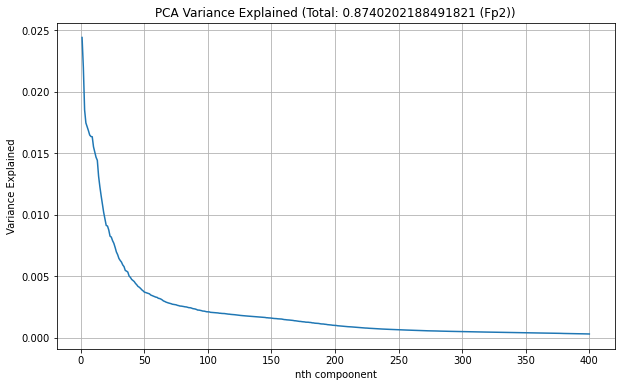

In [11]:
n_range = range(1, 401)
plt.figure(figsize = (10, 6))
plt.plot(n_range, fp2_ratios)
plt.title('PCA Variance Explained (Total: {} (Fp2))'.format(fp2_ratios.sum()))
plt.xlabel('nth compoonent')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()

In [12]:
totals = []
t = 0
for i in range(len(fp2_ratios)):
    t += fp2_ratios[i]
    totals.append(t)

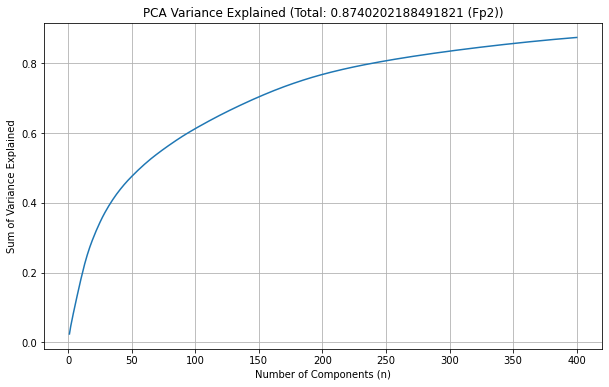

In [13]:
n_range = range(1, 401)
plt.figure(figsize = (10, 6))
plt.plot(n_range, totals)
plt.title('PCA Variance Explained (Total: {} (Fp2))'.format(fp2_ratios.sum()))
plt.xlabel('Number of Components (n)')
plt.ylabel('Sum of Variance Explained')
plt.grid(True)
plt.show()

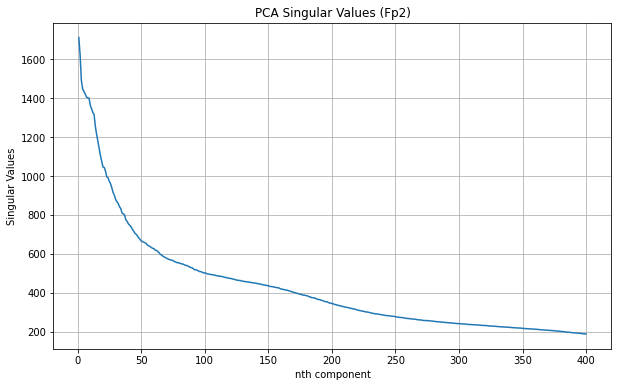

In [14]:
n_range = range(1, 401)
plt.figure(figsize = (10, 6))
plt.plot(n_range, fp2_svalues)
plt.title('PCA Singular Values (Fp2)')
plt.xlabel('nth component')
plt.ylabel('Singular Values')
plt.grid(True)
plt.show()

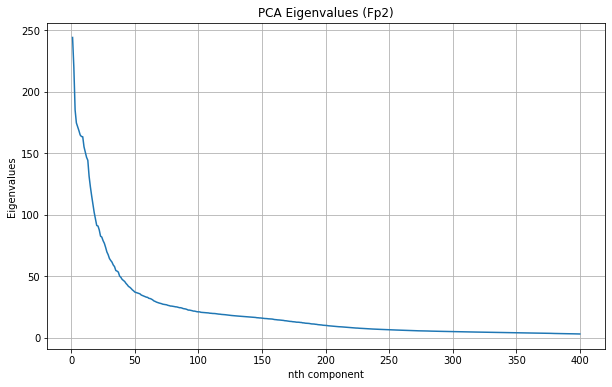

In [15]:
n_range = range(1, 401)
plt.figure(figsize = (10, 6))
plt.plot(n_range, fp2_evalues)
plt.title('PCA Eigenvalues (Fp2)')
plt.xlabel('nth component')
plt.ylabel('Eigenvalues')
plt.grid(True)
plt.show()

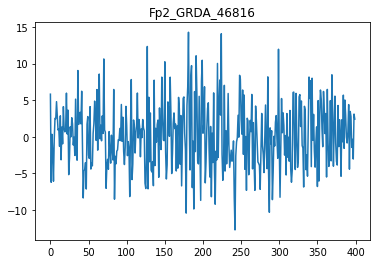

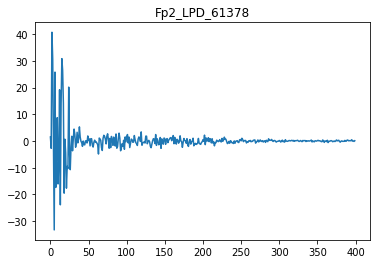

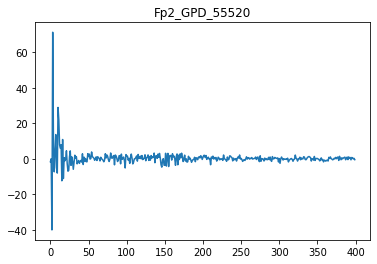

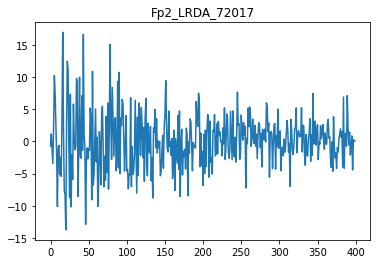

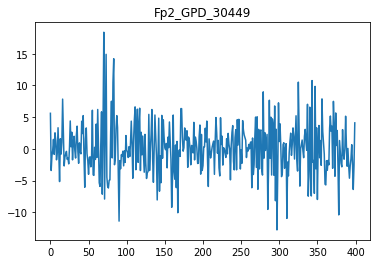

In [16]:
to_plot = np.random.choice(fp2_pca.columns, size = 5, replace = False)
for i in to_plot:
    plt.plot(fp2_pca[i])
    plt.title('{}'.format(i))
    plt.show()

### F8

In [17]:
f8_signals = pd.read_parquet('electrode_matrices/F8_signals.parquet', engine = 'pyarrow')

In [18]:
f8_pca, f8_ratios, f8_svalues, f8_evalues = pca_function(f8_signals, 400)

In [19]:
f8_pca = f8_pca.transpose()

In [20]:
f8_pca.columns = ['F8_{}_{}'.format(activity_indexes['activity_type'][i],
                                    activity_indexes['index'][i]) for i in range(f8_pca.shape[1])]

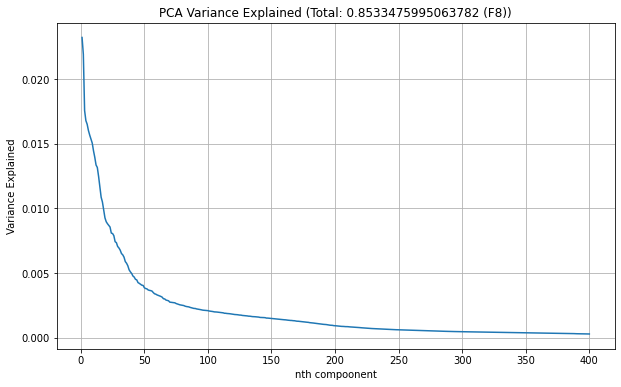

In [21]:
n_range = range(1, 401)
plt.figure(figsize = (10, 6))
plt.plot(n_range, f8_ratios)
plt.title('PCA Variance Explained (Total: {} (F8))'.format(f8_ratios.sum()))
plt.xlabel('nth compoonent')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()

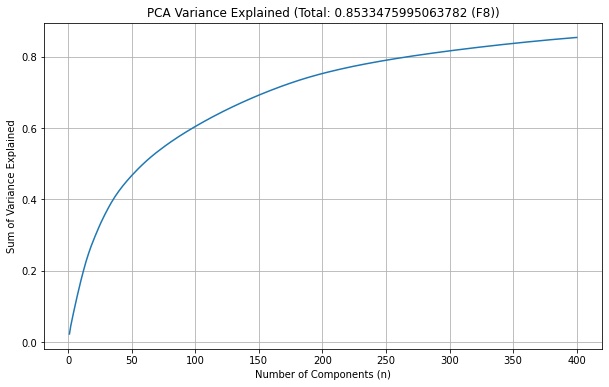

In [22]:
totals = []
t = 0
for i in range(len(f8_ratios)):
    t += f8_ratios[i]
    totals.append(t)

n_range = range(1, 401)
plt.figure(figsize = (10, 6))
plt.plot(n_range, totals)
plt.title('PCA Variance Explained (Total: {} (F8))'.format(f8_ratios.sum()))
plt.xlabel('Number of Components (n)')
plt.ylabel('Sum of Variance Explained')
plt.grid(True)
plt.show()

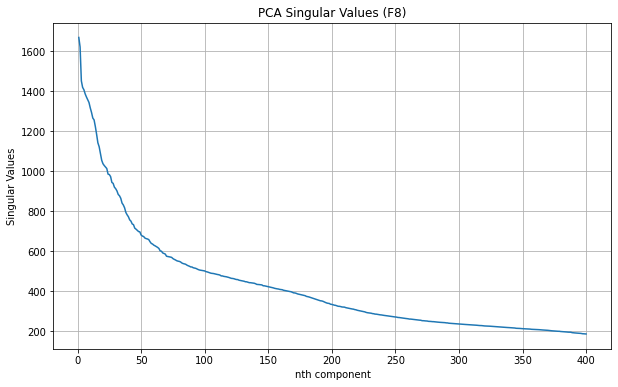

In [23]:
n_range = range(1, 401)
plt.figure(figsize = (10, 6))
plt.plot(n_range, f8_svalues)
plt.title('PCA Singular Values (F8)')
plt.xlabel('nth component')
plt.ylabel('Singular Values')
plt.grid(True)
plt.show()

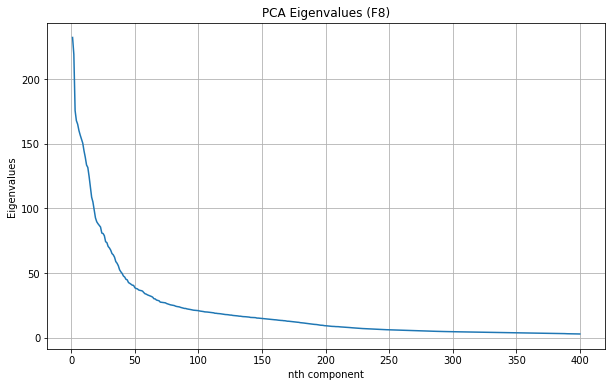

In [24]:
n_range = range(1, 401)
plt.figure(figsize = (10, 6))
plt.plot(n_range, f8_evalues)
plt.title('PCA Eigenvalues (F8)')
plt.xlabel('nth component')
plt.ylabel('Eigenvalues')
plt.grid(True)
plt.show()

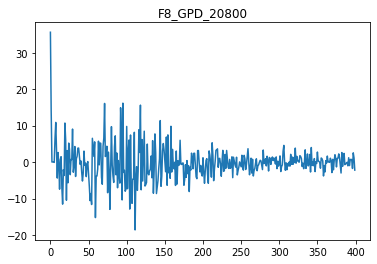

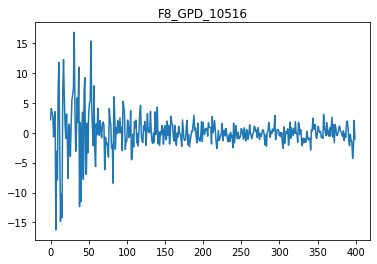

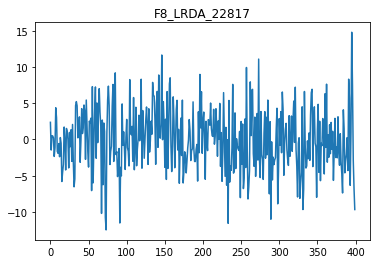

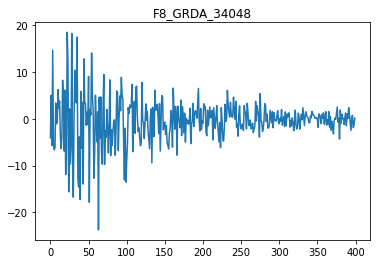

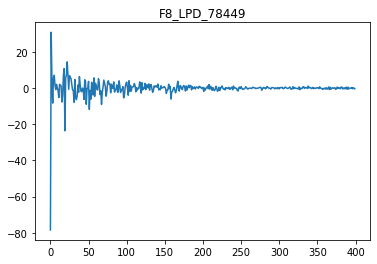

In [25]:
to_plot = np.random.choice(f8_pca.columns, size = 5, replace = False)
for i in to_plot:
    plt.plot(f8_pca[i])
    plt.title('{}'.format(i))
    plt.show()

### T4

In [26]:
t4_signals = pd.read_parquet('electrode_matrices/T4_signals.parquet', engine = 'pyarrow')
t4_pca, t4_ratios, t4_svalues, t4_evalues = pca_function(t4_signals, 400)

In [27]:
t4_pca = t4_pca.transpose()
t4_pca.columns = ['T4_{}_{}'.format(activity_indexes['activity_type'][i], 
                                   activity_indexes['index'][i]) for i in range(t4_pca.shape[1])]

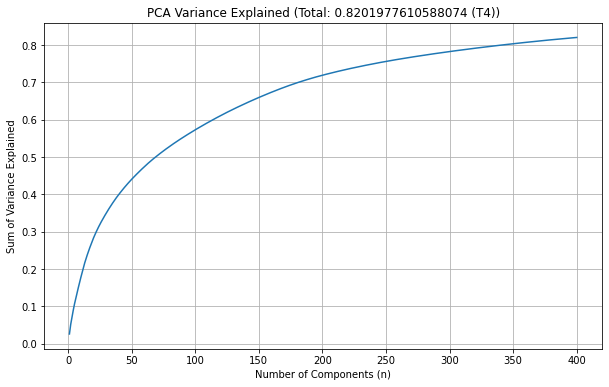

In [28]:
totals = []
t = 0
for i in range(len(t4_ratios)):
    t += t4_ratios[i]
    totals.append(t)

n_range = range(1, 401)
plt.figure(figsize = (10, 6))
plt.plot(n_range, totals)
plt.title('PCA Variance Explained (Total: {} (T4))'.format(t4_ratios.sum()))
plt.xlabel('Number of Components (n)')
plt.ylabel('Sum of Variance Explained')
plt.grid(True)
plt.show()

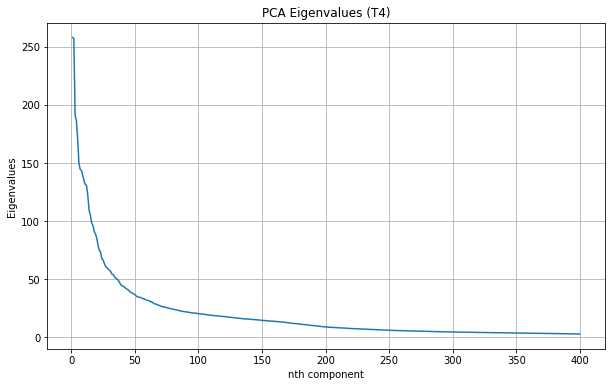

In [29]:
n_range = range(1, 401)
plt.figure(figsize = (10, 6))
plt.plot(n_range, t4_evalues)
plt.title('PCA Eigenvalues (T4)')
plt.xlabel('nth component')
plt.ylabel('Eigenvalues')
plt.grid(True)
plt.show()

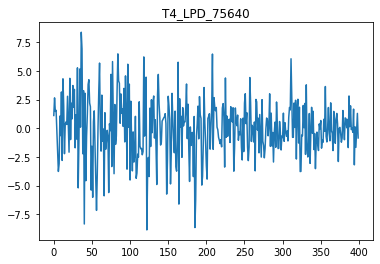

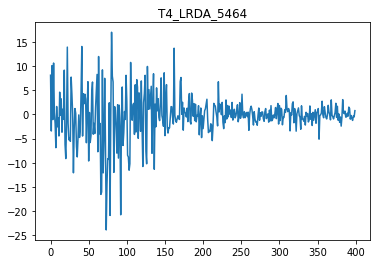

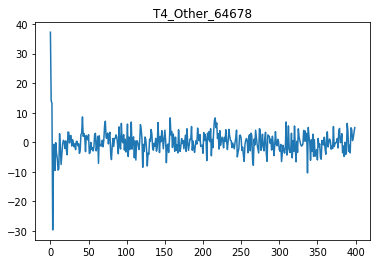

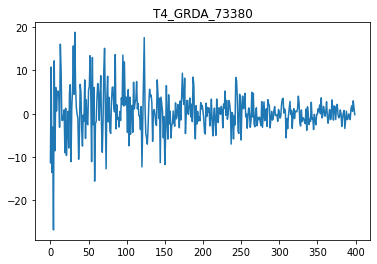

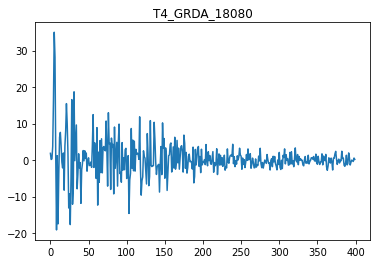

In [31]:
to_plot = np.random.choice(t4_pca.columns, size = 5, replace = False)
for i in to_plot:
    plt.plot(t4_pca[i])
    plt.title('{}'.format(i))
    plt.show()

### T6

In [32]:
t6_signals = pd.read_parquet('electrode_matrices/T6_signals.parquet', engine = 'pyarrow')
t6_pca, t6_ratios, t6_svalues, t6_evalues = pca_function(t6_signals, 400)

In [33]:
t6_pca = t6_pca.transpose()
t6_pca.columns = ['T6_{}_{}'.format(activity_indexes['activity_type'][i], 
                                   activity_indexes['index'][i]) for i in range(t6_pca.shape[1])]

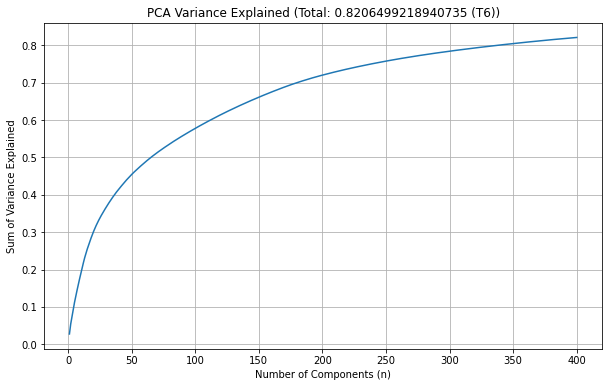

In [34]:
totals = []
t = 0
for i in range(len(t6_ratios)):
    t += t6_ratios[i]
    totals.append(t)

n_range = range(1, 401)
plt.figure(figsize = (10, 6))
plt.plot(n_range, totals)
plt.title('PCA Variance Explained (Total: {} (T6))'.format(t6_ratios.sum()))
plt.xlabel('Number of Components (n)')
plt.ylabel('Sum of Variance Explained')
plt.grid(True)
plt.show()

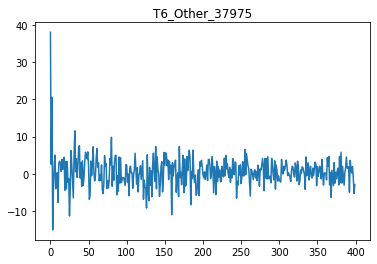

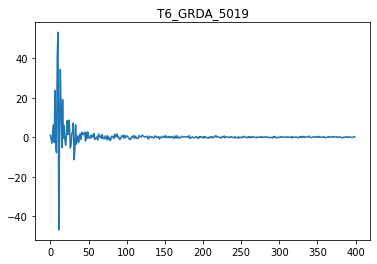

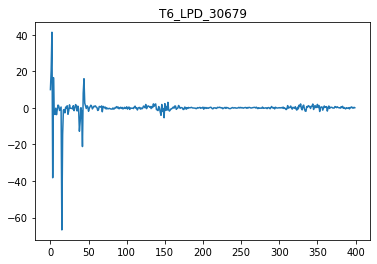

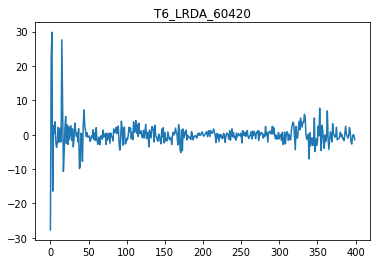

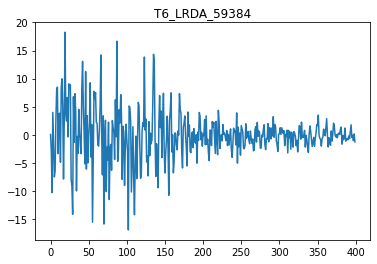

In [35]:
to_plot = np.random.choice(t6_pca.columns, size = 5, replace = False)
for i in to_plot:
    plt.plot(t6_pca[i])
    plt.title('{}'.format(i))
    plt.show()

### O2

In [36]:
o2_signals = pd.read_parquet('electrode_matrices/O2_signals.parquet', engine = 'pyarrow')
o2_pca, o2_ratios, o2_svalues, o2_evalues = pca_function(o2_signals, 400)

In [37]:
o2_pca = o2_pca.transpose()
o2_pca.columns = ['O2_{}_{}'.format(activity_indexes['activity_type'][i], 
                                   activity_indexes['index'][i]) for i in range(o2_pca.shape[1])]

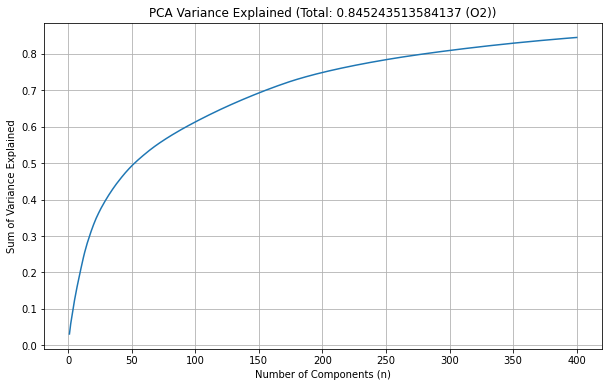

In [38]:
totals = []
t = 0
for i in range(len(o2_ratios)):
    t += o2_ratios[i]
    totals.append(t)

n_range = range(1, 401)
plt.figure(figsize = (10, 6))
plt.plot(n_range, totals)
plt.title('PCA Variance Explained (Total: {} (O2))'.format(o2_ratios.sum()))
plt.xlabel('Number of Components (n)')
plt.ylabel('Sum of Variance Explained')
plt.grid(True)
plt.show()

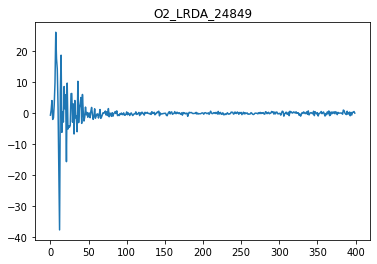

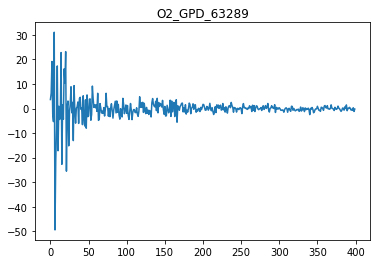

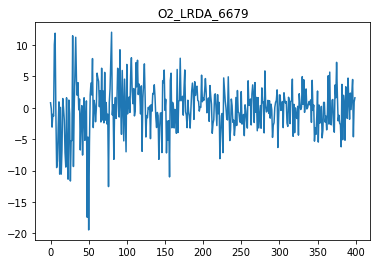

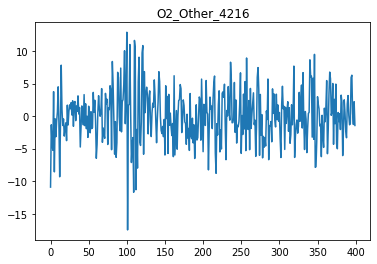

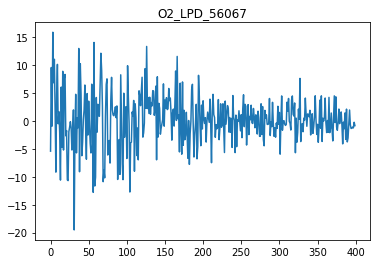

In [39]:
to_plot = np.random.choice(o2_pca.columns, size = 5, replace = False)
for i in to_plot:
    plt.plot(o2_pca[i])
    plt.title('{}'.format(i))
    plt.show()

### Clustering with PCA Data